# M1. URBAN MOVEMENT MODEL

En este reporte se mostrará una simulación del tráfico que se genera en una intersección de cuatro diferentes calles, con dos carriles cada una de ellas.

## Descripción del Reto

El tráfico es un problema que va en aumento debido al incremento en población de las ciudades, esto a su vez aparte de hacer perder tiempo a las personas en el congestionamiento que se genera por los semáforos, hace perder dinero y genera mayor contaminación al tener que utilizar más gasolina en un número de automóviles incrementado. Para dar solución a este problema se ha intentado ampliar la infraestructura con la finalidad de dar más opciones de rutas a los usuarios y de esta manera aliviar el tráfico. También se ha restringido en ciertas ciudades la circulación por días dependiendo del último dígito de la placa de los automóviles a pesar de que no en todos sus casos de aplicación resultó ser una medida eficiente ya que los usuarios en lugar de utilizar transporte público, adquirió un mayor número de automóviles con la finalidad de poder circular todos los días posibles. 


## ¿Cómo funciona el modelo?

Para la solución del reto se asume que cada calle será doble carril y de doble sentido, los únicos colores de semáforos que se utilizarán serán el verde y rojo. Todos los vehículos utilizarán las mismas magnitudes de aceleración, desaceleración para el frenado e iran a la máxima velocidad permitida de 60 km/h. Para visualizar la solución de congestión de tráfico se representará de forma gráfica el cruce de 2 calles, es decir de una intersección, en la que cada carro podrá tomar cualquier dirección aleatoriamente. Al representar una intersección existirán 4 semáforos, uno por cada entrada de carros a la misma y se asume que tan solo 1 de ellos podrá estar encendido a la vez.


In [191]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np

import random
from collections import deque
from math import ceil

In [192]:
class CarAgent(Agent):
    def __init__(self, unique_id, model, origin, destiny, stop_distance, road_number, curve_origin, curve_destiny, num_traffic_light, light_agent):
        super().__init__(unique_id, model)
        
        # Initial spawn position
        self.type = "Car"
        self.position = np.array((origin[0], origin[1]), dtype = np.float64)
        self.origin_road = np.array((origin[0], origin[1]), dtype = np.float64)
        self.destiny_road = destiny
        self.stop_distance = stop_distance
        self.next_car_min_distance = stop_distance
        self.road_number = road_number
        self.curve_origin = curve_origin
        self.curve_destiny = curve_destiny
        self.num_traffic_light = num_traffic_light
        self.light_agent = light_agent
        self.light_agent.n_cars += 1
        # Speed limit
        self.max_speed = self.stop_distance
        self.crossed_traffic_light = None
        self.total_wait = 0
        self.curved_finished = False

        if (self.num_traffic_light == 0):
            self.speed = np.array([0, (self.stop_distance / 4)])
            self.acceleration = np.array([0, (self.stop_distance / 4)])
        elif (self.num_traffic_light == 1):
            self.speed = np.array([-(self.stop_distance / 4), 0])
            self.acceleration = np.array([-(self.stop_distance / 4), 0])
        elif (self.num_traffic_light == 2):
            self.speed = np.array([0, -(self.stop_distance / 4)])
            self.acceleration = np.array([0, -(self.stop_distance / 4)])
        elif (self.num_traffic_light == 3):
            self.speed = np.array([(self.stop_distance / 4), 0])
            self.acceleration = np.array([(self.stop_distance / 4), 0])


    def move_start(self):
        # Determine if car is the first one of the road
        is_front = (self.model.roads_agents[self.road_number][0].unique_id == self.unique_id)
        
        if (is_front and (self.light_agent.status == 1 or self.is_far_from_traffic_light())) or self.is_far_from_next_car(is_front):
            if(self.has_to_curve() and self.will_cross_traffic_light()):
                self.position += self.acceleration
                self.update_when_crossed()
            else:
                self.position += self.speed
                self.speed += self.acceleration
            
                if np.linalg.norm(self.speed) > self.max_speed:
                    self.speed = self.speed / np.linalg.norm(self.speed) * self.max_speed

                if self.crossed_traffic_light == None and self.is_about_cross_traffic_light():
                    self.crossed_traffic_light = False
                    self.light_agent.crossing_cars += 1
        else:
            if np.linalg.norm(self.speed) > 0:
                self.speed -= self.acceleration
                self.position += self.speed
            elif np.linalg.norm(self.speed) == 0:
                self.model.total_wait_time += 1
                self.light_agent.sum_total_wait += 1
                self.total_wait += 1
            else:
                self.speed *= 0

        if self.has_crossed_traffic_light() and self.crossed_traffic_light != True:
            self.update_when_crossed()


    def update_when_crossed(self):
        if self.crossed_traffic_light == False:
            self.light_agent.crossing_cars -= 1
        self.crossed_traffic_light = True
        self.light_agent.n_cars -= 1
        self.light_agent.sum_total_wait -= self.total_wait
        self.total_wait = 0
        # Deque car from road
        self.model.roads_agents[self.road_number].popleft()
        # If it has to curve to reach destiny
        if self.has_to_curve():
            self.curve_points = self.curve(self.position, self.curve_destiny)
            self.temp = 0
            self.move_curve()
        # No curve, go forward
        else:
            self.curved_finished = True
            self.move_destination()


    def move_curve(self):
        if self.temp < len(self.curve_points):
            vec = (self.curve_points[self.temp][0] - self.position)
            self.speed = vec
            self.position += self.speed
            self.temp += 2
        else:
            self.curved_finished = True
            self.move_destination()

    def move_destination(self):
        self.speed = self.destiny_road - self.position
        if np.linalg.norm(self.speed) > self.max_speed:
            self.speed = self.speed / np.linalg.norm(self.speed) * self.max_speed
        self.position += self.speed

    def step(self):
        if self.crossed_traffic_light != True:
            self.move_start()
        elif self.curved_finished == True:
            self.move_destination()
        else:
            self.move_curve()

    def get_car_index(self):
        bot = 0
        top = len(self.model.roads_agents[self.road_number]) - 1
        target_id = self.unique_id
        # Binary Search
        while bot <= top:
            mid = int (bot + (top - bot) / 2)
            current_id = self.model.roads_agents[self.road_number][mid].unique_id
            
            if current_id == target_id:
                return mid
            elif current_id > target_id:
                top = mid - 1
            else:
                bot = mid + 1
            
        return -1


    def is_far_from_traffic_light(self):
        return (abs(np.linalg.norm(self.position + self.speed - self.curve_origin)) > self.stop_distance)


    def is_about_cross_traffic_light(self):
        return (abs(np.linalg.norm(self.position + self.speed - self.curve_origin)) < self.stop_distance * 1.5)


    def is_far_from_next_car(self, is_front):
        if is_front:
            return False
        else:
            queue_position = self.get_car_index()
            next_car = self.model.roads_agents[self.road_number][queue_position - 1]
            self_speed = np.linalg.norm(self.speed)
            self_acceleration = np.linalg.norm(self.acceleration)
            distance_to_stop = abs(0.5 * self_speed * self_speed / self_acceleration) + self.next_car_min_distance
            return (abs(np.linalg.norm((self.position + self.speed) - (next_car.position + next_car.speed))) > distance_to_stop)

    def has_crossed_traffic_light(self):
        return (abs(np.linalg.norm(self.position - self.origin_road)) \
                    > abs(np.linalg.norm(self.curve_origin - self.origin_road)))
    
    def will_cross_traffic_light(self):
        return (abs(np.linalg.norm(self.position + self.speed - self.origin_road)) \
                    > abs(np.linalg.norm(self.curve_origin - self.origin_road)))

    def has_to_curve(self):
        return (self.position[0] - self.curve_destiny[0]) * (self.position[1] - self.curve_destiny[1]) != 0


    def curve_points(self, start, end, control, resolution = 5):
        path = []
        for i in range(resolution+1):
            t = i/resolution
            x = (1-t)**2 * start[0] + 2*(1-t)*t * control[0] + t**2 * end[0]
            y = (1-t)**2 * start[1] + 2*(1-t)*t * control[1] + t**2 * end[1]
            path.append((x, y))

        return [(path[i-1], path[i]) for i in range(1, len(path))]


    def curve(self, start, end):
        turn_direction = 0
        resolution = 15
        if (self.num_traffic_light == 0):
            if (end[0] > start[0] and end[1] > start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] < start[0] and end[1] > start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 1):
            if (end[0] < start[0] and end[1] > start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] < start[0] and end[1] < start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 2):
            if (end[0] < start[0] and end[1] < start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] > start[0] and end[1] < start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 3):
            if (end[0] > start[0] and end[1] < start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] > start[0] and end[1] > start[1]):
                turn_direction = 1


        CLOCK_WISE = 0
        # Get control point
        x = min(start[0], end[0])
        y = min(start[1], end[1])

        if turn_direction == CLOCK_WISE:
            control = (x - y + start[1], y - x + end[0])
        else:
            control = (x - y + end[1], y - x + start[0])
        
        return self.curve_points(start, end, control, resolution=resolution)


In [193]:
class TrafficLightAgent(Agent):
    def __init__(self, unique_id, model, pos, max_on, max_off, intelligent):
        super().__init__(unique_id, model)
        
        self.type = "TrafficLight"
        self.color = "red"
        self.status = 0
        self.max_time_on = max_on
        self.max_time_off = max_off
        self.intelligent = intelligent
        self.n_cars = 0
        self.crossing_cars = 0
        self.sum_total_wait = 0
        self.time_on = 0
        self.wait_off = 0
        self.position = np.array((pos[0], pos[1]), dtype = np.float64)
    
    def step(self):
        if self.status == 1:
            self.wait_off = 0
            self.time_on += 1
            if self.intelligent == True and (self.time_on >= self.max_time_on or self.crossing_cars == 0):
                self.status = 0
                self.color = "red"
                self.time_on = 0
            elif not self.intelligent and self.time_on >= self.max_time_on:
                self.status = 0
                self.color = "red"
                self.time_on = 0
            elif not self.intelligent and self.crossing_cars == 0:
                self.model.time_unnecessary_light += 1
        else:
            if self.n_cars > 0:
                self.wait_off += 1

In [194]:
def get_agents(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result


class UrbanMovementModel(Model):
    def __init__(self, spawn_cars, w, h, i_dist, max_on, max_off, seed = 1, intelligent = True):
        random.seed(seed)
        np.random.seed(seed)
        self.num_agents = 0
        self.spawn_cars = spawn_cars
        self.width = w
        self.height = h
        self.schedule = RandomActivation(self)
        self.i_dist = i_dist
        self.max_on = max_on
        self.max_off = max_off
        self.actual_light = None
        self.past_light = None
        self.delay_next_light = 0
        self.intelligent = intelligent
        self.total_wait_time = 0
        self.time_unnecessary_light = 0
        
        # (carril, semáforo, [carriles destino], direction)
        self.intersection = [(1, 1, [8, 12]), (2, 1, [3, 7]), 
                            (5, 2, [12, 16]), (6, 2, [7, 11]),
                            (9, 3, [4, 16]), (10, 3, [11, 15]), 
                            (13, 4, [4, 8]), (14, 4, [3, 15])]
        
        self.road_pos = [[w / 2 + i_dist / 8, 0], [w / 2 + i_dist / 8 * 3, 0],
                        [w, h / 2 - i_dist / 8 * 3], [w, h / 2 - i_dist / 8],
                        [w, h / 2 + i_dist / 8], [w, h / 2 + i_dist / 8 * 3],
                        [w / 2 + i_dist / 8 * 3, h], [w / 2 + i_dist / 8, h],
                        [w / 2 - i_dist / 8, h], [w / 2 - i_dist / 8 * 3, h],
                        [0, h / 2 + i_dist / 8 * 3], [0, h / 2 + i_dist / 8],
                        [0, h / 2 - i_dist / 8], [0, h / 2 - i_dist / 8 * 3],
                        [w / 2 - i_dist / 8 * 3, 0], [w / 2 - i_dist / 8, 0]]

        self.curve = [  [w / 2 + i_dist / 8, h / 2 - i_dist / 2], [w / 2 + i_dist / 8 * 3, h / 2 - i_dist / 2],
                        [w / 2 + i_dist / 2, h / 2 - i_dist / 8 * 3], [w / 2 + i_dist / 2, h / 2 - i_dist / 8], 
                        [w / 2 + i_dist / 2, h / 2 + i_dist / 8], [w / 2 + i_dist / 2, h / 2 + i_dist / 8 * 3],
                        [w / 2 + i_dist / 8 * 3, h / 2 + i_dist / 2], [w / 2 + i_dist / 8, h / 2 + i_dist / 2], 
                        [w / 2 - i_dist / 8, h / 2 + i_dist / 2], [w / 2 - i_dist / 8 * 3, h / 2 + i_dist / 2],
                        [w / 2 - i_dist / 2, h / 2 + i_dist / 8 * 3], [w / 2 - i_dist / 2, h / 2 + i_dist / 8], 
                        [w / 2 - i_dist / 2, h / 2 - i_dist / 8], [w / 2 - i_dist / 2, h / 2 - i_dist / 8 * 3],
                        [w / 2 - i_dist / 8 * 3, h / 2 - i_dist / 2], [w / 2 - i_dist / 8, h / 2 - i_dist / 2]]

        self.light_pos = [[w / 2 + i_dist / 4, h / 2 - i_dist / 2],
                        [w / 2 + i_dist / 2, h / 2 + i_dist / 4],
                        [w / 2 - i_dist / 4, h / 2 + i_dist / 2],
                        [w / 2 - i_dist / 2, h / 2 - i_dist / 4]]
        
        self.roads_agents = [deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), 
                            deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([])]
        
        self.light_agents = []

        self.time_for_spawn = np.array([0, 0, 0, 0, 0, 0, 0, 0])

        self.createLights()

        self.createAgents()

        self.datacollector = DataCollector(model_reporters = {"Agents" : get_agents})


    def createLights(self):
        for i in range(len(self.light_pos)):
            self.num_agents += 1
            light = TrafficLightAgent(self.num_agents, self, self.light_pos[i], self.max_on, self.max_off, self.intelligent)
            self.light_agents.append(light)
            self.schedule.add(light)


    def createAgents(self):
        for i in range(len(self.intersection)):
            if self.time_for_spawn[i] <= 0 and random.random() <= self.spawn_cars:
                self.time_for_spawn[i] = 3
                (road, light, dest) = self.intersection[i]
                j = np.random.randint(len(dest))
                self.num_agents += 1
                car = CarAgent(self.num_agents, 
                            self,
                            self.road_pos[road - 1], 
                            self.road_pos[dest[j] - 1],
                            self.i_dist / 4,
                            road - 1,
                            self.curve[road - 1],
                            self.curve[dest[j] - 1],
                            light - 1,
                            self.light_agents[light - 1])
                self.roads_agents[road - 1].append(car)
                self.schedule.add(car)


    def change_light(self):
        if self.actual_light == None and self.delay_next_light <= 0:
            if self.intelligent == True:
                best_light = None
                best_priority = 0
                for i in range(len(self.light_agents)):
                    actual_light = self.light_agents[i]
                    priority = 0
                    if actual_light.wait_off >= actual_light.max_time_off:
                        priority += (actual_light.wait_off * 5)
                    if actual_light.crossing_cars > 0:
                        priority += ceil(actual_light.sum_total_wait / actual_light.crossing_cars)
                    
                    if priority > best_priority:
                        best_priority = priority
                        best_light = i

                if best_light != None:
                    self.light_agents[best_light].status = 1
                    self.light_agents[best_light].color = "green"
                    self.actual_light = best_light
            else:
                if self.past_light == None:
                    self.actual_light = 0
                else:
                    self.actual_light = (self.past_light + 1) % len(self.light_agents)
                self.light_agents[self.actual_light].status = 1
                self.light_agents[self.actual_light].color = "green"

        elif self.actual_light != None and self.light_agents[self.actual_light].status == 0:
            self.past_light = self.actual_light
            self.actual_light = None
            self.delay_next_light = 4
        else:
            self.delay_next_light -= 1
    
    def get_agents(self):
        car_positions = []
        traffic_lights = []
        for agent in self.schedule.agents:
            if agent.type == "Car":
                car_positions.append(agent.position)
            elif agent.type == "TrafficLight":
                traffic_lights.append(agent.color)
        car_positions = np.asarray(car_positions)
        traffic_lights = np.asarray(traffic_lights)
        return (car_positions, traffic_lights)


    def step(self):
        self.createAgents()
        self.change_light()
        self.time_for_spawn -= 1
        self.datacollector.collect(self)
        self.schedule.step()

In [195]:
WIDTH = 300
HEIGHT = 300
INTERSECT_DIST = 30
PROB_SPAWN = 0.1
MAX_TIME_ON = 40
MAX_TIME_OFF = 150
SEED = 1
INTELLIGENT = True
MAX_ITERATIONS = 300

model = UrbanMovementModel(PROB_SPAWN, WIDTH, HEIGHT, INTERSECT_DIST, MAX_TIME_ON, MAX_TIME_OFF, SEED, INTELLIGENT)
for i in range(MAX_ITERATIONS):
    model.step()
    

In [196]:
all_positions = model.datacollector.get_model_vars_dataframe()

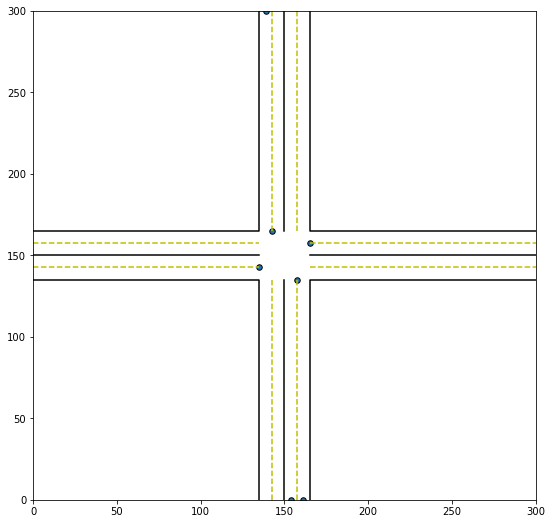

In [197]:
fig, ax = plt.subplots(figsize=(9,9))

# El segundo 0 es el diccionario que estoy manejando; después se utiliza el slice para tomar las x de los vectores de 2.
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                s=30, cmap="jet", edgecolor = "k")

# Corners
x1 = [0, WIDTH / 2 - INTERSECT_DIST / 2, WIDTH / 2 - INTERSECT_DIST / 2]
y1 = [HEIGHT / 2 - INTERSECT_DIST / 2, HEIGHT / 2 - INTERSECT_DIST / 2, 0]
plt.plot(x1, y1, color='black')
y2 = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(x1, y2, color='black')
x2 = [WIDTH, WIDTH / 2 + INTERSECT_DIST / 2, WIDTH / 2 + INTERSECT_DIST / 2]
plt.plot(x2, y2, color='black')
plt.plot(x2, y1, color='black')

# Izquierda
xlane = [0, WIDTH / 2 - INTERSECT_DIST / 2]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Derecha
xlane = [WIDTH / 2 + INTERSECT_DIST / 2, WIDTH]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Abajo
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [0, HEIGHT / 2 - INTERSECT_DIST / 2]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Arriba
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')

for i in range(len(model.curve)):
    plt.plot()

ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    # Arreglo de pares x, y.
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_ITERATIONS)

In [198]:
anim